In [1]:
# this block of code imports graphical libraries for plotting graphs with high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [2]:
!pip install -q usearch


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Libraries of functions need to be imported
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from scipy.spatial.distance import cdist
from usearch.index import search, MetricKind, Matches, BatchMatches
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial import Delaunay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from scipy import linalg
# from scipy.interpolate import interp1d, LinearNDInterpolator, NearestNDInterpolator
# from sklearn.decomposition import PCA

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [5]:
# We will be using mtcars dataset
data = pd.read_csv('https://github.com/dvasiliu/AAML/blob/main/Data%20Sets/mtcars.csv?raw=True')
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [6]:
# We will be having multiple features - cyl, disp, hp, drat, wt, qsec, vs, am, gear, carb
X = data.drop(columns=['model', 'mpg']).values
y = data['mpg'].values

In [7]:
# if we compute distances we need to put the attributes on the same scale
scaler = StandardScaler()
xscaled = scaler.fit_transform(x)

In [8]:
many_in_many: BatchMatches = search(xscaled, xscaled,392 , MetricKind.L2sq, exact=True)

In [9]:
one_in_many: Matches = search(xscaled, xscaled[0], len(xscaled), MetricKind.L2sq, exact=True)

In [10]:
dist = one_in_many.to_list()

In [11]:
dist.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
dist

[(0, 0.0),
 (185, 0.0),
 (71, 0.0),
 (134, 0.0),
 (91, 0.0),
 (26, 0.0),
 (283, 0.0),
 (37, 0.0),
 (11, 0.0),
 (5, 0.0),
 (65, 0.0),
 (228, 0.0),
 (210, 0.0),
 (7, 0.0),
 (92, 0.0),
 (66, 0.0),
 (41, 0.0),
 (9, 0.0),
 (93, 0.0),
 (85, 0.0),
 (90, 0.0),
 (62, 0.0),
 (64, 0.0),
 (286, 0.0),
 (227, 0.0),
 (38, 0.0),
 (40, 0.0),
 (67, 0.0),
 (4, 0.0),
 (288, 0.0),
 (63, 0.0),
 (155, 0.0),
 (287, 0.0),
 (61, 0.0),
 (86, 0.0),
 (89, 0.0),
 (220, 0.0),
 (88, 0.0),
 (247, 0.0),
 (72, 0.0),
 (1, 0.0),
 (87, 0.0),
 (3, 0.0),
 (25, 0.0),
 (186, 0.0),
 (154, 0.0),
 (6, 0.0),
 (211, 0.0),
 (136, 0.0),
 (135, 0.0),
 (102, 0.0),
 (84, 0.0),
 (285, 0.0),
 (8, 0.0),
 (10, 0.0),
 (2, 0.0),
 (284, 0.0),
 (103, 0.0),
 (219, 0.0),
 (39, 0.0),
 (133, 0.1599999964237213),
 (248, 0.1599999964237213),
 (282, 0.1599999964237213),
 (36, 0.1599999964237213),
 (221, 0.1599999964237213),
 (261, 0.1599999964237213),
 (226, 0.1599999964237213),
 (156, 0.1599999964237213),
 (260, 0.1599999964237213),
 (42, 0.159999996

In [ ]:
distances = cdist(xscaled,xscaled,metric='Euclidean')

In [ ]:
distances.shape

(392, 392)

### Kernels for the Weights

In [ ]:
# Gaussian Kernel
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))

In [ ]:
# this is the correct vectorized version
def Tricubic(x):
  return np.where(np.abs(x)>1,0,(1-np.abs(x)**3)**3)

In [ ]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))

In [ ]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)

In [ ]:
def kernel_function(d_ij,kern, tau):
    return kern(d_ij/(2*tau))

In [ ]:
# we want the weights
kern = Gaussian

In [ ]:
weights = kernel_function(distances,kern,tau=0.05)

In [ ]:
weights

array([[0.39894228, 0.18641149, 0.37609268, ..., 0.        , 0.        ,
        0.        ],
       [0.18641149, 0.39894228, 0.2173439 , ..., 0.        , 0.        ,
        0.        ],
       [0.37609268, 0.2173439 , 0.39894228, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.39894228, 0.23888698,
        0.1772128 ],
       [0.        , 0.        , 0.        , ..., 0.23888698, 0.39894228,
        0.3846016 ],
       [0.        , 0.        , 0.        , ..., 0.1772128 , 0.3846016 ,
        0.39894228]])

### What happens next?

Answer: we multiply the weights with the data and we solve n linear regression problems.

In [ ]:
# one set of weights is weights[:,0]
model = Ridge(alpha=0.001,max_iter=5000)

In [ ]:
model.fit(np.diag(weights[:,0])@xscaled, np.diag(weights[:,0])@y)

Ridge(alpha=0.001, max_iter=5000)

In [ ]:
model.predict(xscaled[0].reshape(1,-1))

array([17.06248486])

In [ ]:
y[0]

18.0

# 새로운 lowess 클래스

In [ ]:
# 1. 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.exceptions import NotFittedError

In [ ]:
# 2. 데이터셋 로딩 및 전처리
# cars.csv 데이터셋을 사용하여 피처(X)와 타겟(y)을 나눈 후, 데이터를 정규화하는 절차
path = '/content/cars (4).csv'
data = pd.read_csv(path)

# 피처와 타겟 분리
X = data.drop(columns=['MPG']).values  # Features: CYL, ENG, WGT
y = data['MPG'].values  # Target: MPG (Miles Per Gallon)

# 스케일링 적용
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# 3. 커널 함수 정의 Cauchy Kernel (새로운 방식)
# 기존 가우시안 커널 -->  Cauchy Kernel과 Tricubic Kernel을 추가하여, 다양한 커널 옵션을 제공
# # 가우시안 커널 (기존 방식)
# def Gaussian(x):
#     return np.where(np.abs(x) > 4, 0, 1 / (np.sqrt(2 * np.pi)) * np.exp(-1/2 * x**2))

def Cauchy(x):
    return 1 / (1 + x**2)

# Tricubic Kernel (추가로 사용)
def Tricubic(x):
    return np.where(np.abs(x) > 1, 0, (1 - np.abs(x)**3)**3)


In [ ]:
# 4. 가중치 함수 및 거리 계산
# LOESS의 핵심인 거리 계산과 가중치 행렬 계산을 포함.
# 거리는 유클리드 거리를 사용하고, 커널을 적용해 각 데이터 포인트에 가중치를 부여
def kernel_function(distances, kernel, tau):
    return kernel(distances / (2 * tau))

# 거리 계산 함수 (유클리드 거리 사용)
def calculate_distances(X):
    return cdist(X, X, metric='euclidean')


In [ ]:
# 5. Lowess 클래스 작성
# 기존 코드 흐름 절차는 유지 하되,
# 새로운 커널과 GridSearchCV에 적합한 구조를 포함해 get_params와 set_params를 추가.

class Lowess(BaseEstimator, RegressorMixin):
    def __init__(self, kernel=Cauchy, tau=0.1, regularization=0.001):
        self.kernel = kernel
        self.tau = tau
        self.regularization = regularization
        self.fitted_ = False  # fit 여부를 추적하기 위한 변수 추가

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

        # 거리 계산
        self.distances = calculate_distances(self.X_train)

        # 가중치 계산
        self.weights = kernel_function(self.distances, self.kernel, self.tau)

        # fit 완료 표시
        self.fitted_ = True  # 모델이 학습되었음을 표시

    def predict(self, X_new):
        if not self.fitted_:
            raise NotFittedError(f"This Lowess instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")

        predictions = []

        for i in range(len(X_new)):
            w = self.weights[:, i]
            model = Ridge(alpha=self.regularization)
            model.fit(np.diag(w) @ self.X_train, np.diag(w) @ self.y_train)
            prediction = model.predict(X_new[i].reshape(1, -1))
            predictions.append(prediction)

        return np.array(predictions)

    # Scikit-learn과 호환되기 위해 get_params, set_params 추가
    def get_params(self, deep=True):
        return {"kernel": self.kernel, "tau": self.tau, "regularization": self.regularization}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [ ]:
# 6. 모델 훈련 및 예측
# 데이터를 사용하여 모델을 훈련, 예측 수행
# train_test_split을 사용하여 데이터를 훈련 및 테스트 세트로 나눕

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Lowess 모델 학습
model = Lowess(kernel=Cauchy, tau=0.15)
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 예측 결과 확인
print(y_pred[:5])
print(y_test[:5])


[[ 9.5495056 ]
 [31.74452208]
 [10.16949669]
 [ 5.49252384]
 [31.89069237]]
[26.       21.6      36.099998 26.       27.      ]


In [ ]:
# 7. 모델 성능 평가
# 모델 성능을 **평균 제곱 오차(MSE)**로 평가

from sklearn.metrics import mean_squared_error

# MSE 계산
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 2493.717088612443


In [ ]:
# 8. GridSearchCV를 사용한 하이퍼파라미터 튜닝
# GridSearchCV를 사용하여 tau 값을 최적화

# GridSearchCV를 사용한 하이퍼파라미터 최적화
param_grid = {'tau': np.linspace(0.01, 0.5, 10)}
grid_search = GridSearchCV(Lowess(), param_grid, scoring='neg_mean_squared_error', cv=5)

# 최적의 tau 값 찾기
grid_search.fit(X_train, y_train)
best_tau = grid_search.best_params_['tau']

print(f"Best tau: {best_tau}")

# 최적의 tau를 사용하여 모델 학습
best_model = Lowess(kernel=Cauchy, tau=best_tau)
best_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 및 성능 평가
best_y_pred = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, best_y_pred)
print(f"Optimized Mean Squared Error: {best_mse}")


Best tau: 0.5
Optimized Mean Squared Error: 351.41695387566307


## 부연설명
### 커널 함수의 설명

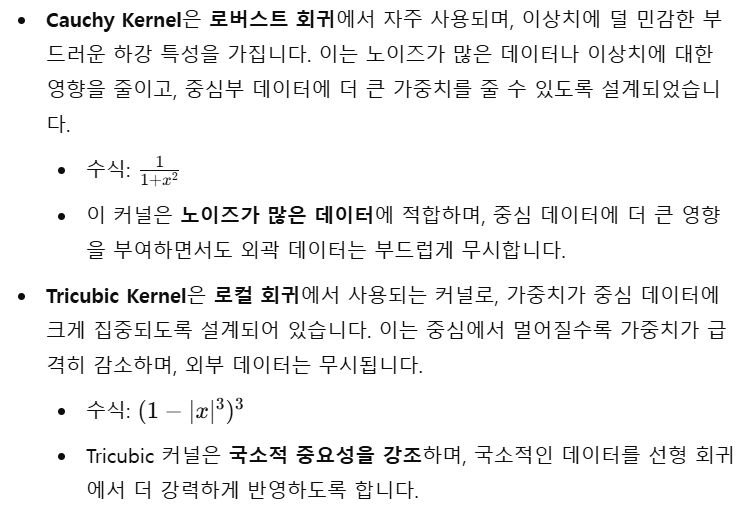